# Preferential Attachment from Epistemic Space


Importing required libraries

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import clear_output

Define parameters of the model

In [2]:
number_of_authors=100
initial_connections=10
time_steps=100
attempt_per_time_step=10



Function to initialize the epistemic space with random values

In [155]:
def initialize_epistemic_space(number_of_authors):
    """
    Initializes the 2D Epistemic Space with random values
 
    Args:
        number_of_authors (int): Number of authors in the epistemic space
 
    Returns:
        float: 2D array with values between 0 and 1
    """
    epistemic_space=[]
    for i in range(number_of_authors):
        epistemic_space.append([np.random.random(),np.random.random()])
        
    return(epistemic_space)




Function to initialize the epistemic space with uniform values on a grid

In [ ]:
def initialize_agents_grid(number_of_authors):
    """
    Initializes the 2D Epistemic Space with uniform values on a grid
 
    Args:
        number_of_authors (int): Number of authors in the epistemic space
 
    Returns:
        float: 2D array with values between 0 and 1
    """
    epistemic_space=[]
    for i in range(10):
        for j in range(10):
            
            epistemic_space.append([(i+0.05)/10,(j+0.05)/10])
        
    return(epistemic_space) 

Function to initialize the network with initial edges

In [4]:
def initialize_network(number_of_authors,initial_connections):
    """
    Initialize a network with given initial connections
 
    Args:
        number_of_authors (int): Number of nodes of the graph
        initial_connections (int): Initial number of edges in the graph
 
    Returns:
        Graph: with number of nodes and initial edges
    """
    G = nx.erdos_renyi_graph(number_of_authors,0)
    nodes = list(G.nodes())
    for i in range(initial_connections):
        node1,node2=np.random.choice(nodes,size=2)
        G.add_edge(node1,node2)
    return(G)



Function to return degree of each node of a network

In [5]:
def list_degrees(G):
    """
    Returns the degrees of each node of a graph
 
    Args:
        G (Graph): Network of authors
 
    Returns:
        int: 1D array with elements as degree of each node
    """
    nodes=list(G.nodes())
    return(np.array([G.degree(node) for node in nodes]))

Function that executes the W model(where we choose nodes which minimize the epistemic distance)
We choose 1 node at random and then find a node among 10 randomly chosen nodes that has the minimum epistemic distance from the chosen node

In [6]:

def W_model(epistemic_space,G):
    """
    Returns 2 nodes of a graph based on W model
 
    Args:
        epistemic space (float): Number of nodes of the graph
        G (graph): Network of authors
 
    Returns:
        int: 2 nodes of the given graph G
    """
    
    nodes = list(G.nodes())
    node1=np.random.choice(nodes,size=1)
    nodes.remove(node1)
    nodes2=np.random.choice(nodes,size=10)
    distances=[]
    point1=np.array([epistemic_space[node1[0]][0],epistemic_space[node1[0]][1]])
    for j in range(len(nodes2)):
        

        
        point2=np.array([epistemic_space[j][0],epistemic_space[j][1] ])
        dist = np.linalg.norm(point1 - point2)
        distances.append(dist)
        
    return(node1[0],nodes2[np.where(distances==min(distances))[0][0]])

Function that executes the P model(where we choose nodes which maximizes mean prestige) We choose 1 node at random with $probabilty(node) = \frac{degree(node)}{Sum(degrees)}$ 
Then find a node among 10 randomly chosen nodes that has the highest degree

In [7]:

def P_model(G):
    """
    Returns 2 nodes of a graph based on P model
 
    Args:
        G (graph): Network of authors
 
    Returns:
        int: 2 nodes of the given graph G
    """
    nodes = list(G.nodes())
    degrees = list_degrees(G)
    node1=np.random.choice(nodes)
    nodes.remove(node1)
    nodes2=np.random.choice(nodes,size=10)
    return(node1,nodes2[np.where(degrees[nodes2]==max(degrees[nodes2]))[0][0]])

Function that updates epistemic coverage of each publication

In [8]:
def calculate_epistemic_coverage(epistemic_space,G,node1,node2,epistemic_coverage):
     """
    Returns 2 nodes of a graph based on W model
 
    Args:
        epistemic space (float): Number of nodes of the graph
        G (graph): Network of authors
        node1 (int): 1st node
        node2 (int): 2nd node
        epistemic coverage(float): 2D array with each point representing a publication
    Returns:
        float: 2D array with new added publications
    """
    m1=G.degree(node1)
    m2=G.degree(node2)
    x1=epistemic_space[node1][0]
    x2=epistemic_space[node2][0]
    y1=epistemic_space[node1][1]
    y2=epistemic_space[node2][1]
    
    point1=float((m1*x1 + m2*x2)/(m1+m2) )
    point2=float((m1*y1 + m2*y2)/(m1+m2))
    
    epistemic_coverage.append([point1,point2])

Function that calculates the acceptance probability of publication using P model

In [9]:
def acceptance_Prob_Publication(G,node1,node2):
    """
    Returns probability of publication by 2 authors via P model
 
    Args:
        G (graph): Network of authors
        node1 (int): 1st node
        node2 (int): 2nd node
 
    Returns:
        float: probability of publication of given authors
    """
    degrees = list_degrees(G)
    return ((G.degree(node1) + G.degree(node2))/(degrees.sum()))

Function that calculates the acceptance probability of publication using W model

In [10]:
def acceptance_prob_W(epistemic_space,node1,node2):
     """
    Returns probability of publication by 2 authors via W model
 
    Args:
        epistemic space (float): 2D array representing the epistemic space
        node1 (int): 1st node
        node2 (int): 2nd node
 
    Returns:
        float: probability of publication of given authors
    """
    
    point1=np.array([epistemic_space[node1][0],epistemic_space[node1][1]])
    point2=np.array([epistemic_space[node2][0],epistemic_space[node2][1]])
    dist = np.linalg.norm(point1 - point2)
    return(1-(dist/np.sqrt(2)))  

Function that evolves the network by selecting authors by P model

In [11]:


def evolve_network_PP(G,epistemic_space,time_steps,attempt_per_time_step):
    """
    Returns epistemic coverage by evolving network using PP model
 
    Args:
        G (graph): Network of authors
        epistemic space (float): 2D array representing the epistemic space
        time steps (int): Number to time steps for simulation
        attempt per time steps (int): Number of publications per time step
 
    Returns:
        float: 2D array storing values of epistemic coverage
    """
    epistemic_coverage=[]
    for t in range(time_steps):
        b=0
        while(b<10):
            node1,node2 = P_model(G)
            if(G.has_edge(node1,node2)==False):
                if np.random.random() < acceptance_Prob_Publication(G,node1,node2) :
                    G.add_edge(node1,node2)
                    calculate_epistemic_coverage(epistemic_space,G,node1,node2,epistemic_coverage)
                    b=b+1
    return(epistemic_coverage)




Function that evolves the network by selecting authors by W model

In [12]:
def evolve_network_WP(G,epistemic_space,time_steps,attempt_per_time_step):
    """
    Returns epistemic coverage by evolving network using WP model
 
    Args:
        G (graph): Network of authors
        epistemic space (float): 2D array representing the epistemic space
        time steps (int): Number to time steps for simulation
        attempt per time steps (int): Number of publications per time step
 
    Returns:
        float: 2D array storing values of epistemic coverage
    """
    epistemic_coverage=[]
    for t in range(time_steps):
        b=0
        while(b!=10):
            node1,node2 = W_model(epistemic_space,G)
            if(G.has_edge(node1,node2)==False):
                if np.random.random() < acceptance_Prob_Publication(G,node1,node2) :
                    G.add_edge(node1,node2)
                    calculate_epistemic_coverage(epistemic_space,G,node1,node2,epistemic_coverage)
                    b=b+1
                
    return(epistemic_coverage)

Function that evolves the network by selecting authors and publication by W model

In [13]:
def evolve_network_WW(G,epistemic_space,time_steps,attempt_per_time_step):
    """
    Returns epistemic coverage by evolving network using WW model
 
    Args:
        G (graph): Network of authors
        epistemic space (float): 2D array representing the epistemic space
        time steps (int): Number to time steps for simulation
        attempt per time steps (int): Number of publications per time step
 
    Returns:
        float: 2D array storing values of epistemic coverage
    """
    epistemic_coverage=[]
    for t in range(time_steps):
        b=0
        while(b!=10):
            node1,node2 = W_model(epistemic_space,G)
            if(G.has_edge(node1,node2)==False):
                if np.random.random() < acceptance_prob_W(epistemic_space,node1,node2) :
                    G.add_edge(node1,node2)
                    calculate_epistemic_coverage(epistemic_space,G,node1,node2,epistemic_coverage)
                    b=b+1
                
    return(epistemic_coverage)

Function that evolves the network by choosing authors by P model and publication by W model

In [14]:
def evolve_network_PW(G,epistemic_space,time_steps,attempt_per_time_step):
    """
    Returns epistemic coverage by evolving network using PW model
 
    Args:
        G (graph): Network of authors
        epistemic space (float): 2D array representing the epistemic space
        time steps (int): Number to time steps for simulation
        attempt per time steps (int): Number of publications per time step
 
    Returns:
        float: 2D array storing values of epistemic coverage
    """
    epistemic_coverage=[]
    for t in range(time_steps):
        b=0
        while(b!=10):
            node1,node2 = P_model(G)
            if(G.has_edge(node1,node2)==False):
                if np.random.random() < acceptance_prob_W(epistemic_space,node1,node2) :
                    G.add_edge(node1,node2)
                    calculate_epistemic_coverage(epistemic_space,G,node1,node2,epistemic_coverage)
                    b=b+1
                
    return(epistemic_coverage)

Function to draw network sturcture of given graph

In [15]:
def draw_graph(G):
    """
    Draws graph as network 
 
    Args:
        G (graph): Network of authors
 
    Returns:
        graph: network of authors
    """
    fig, ax = plt.subplots()
    pos = nx.spring_layout(G)
    nx.draw(G, pos=pos, with_labels=True, node_size=50, font_size=8)
    plt.show()


Function to plot degree distribution

In [16]:
def plot_degree_distribution(G):
    """
    Plots the degree distribution of any given graph 
 
    Args:
        G (graph): Network of authors
 
    Returns:
        float: 1D array of size equal to number of nodes of network
    """
    degrees = dict(G.degree())

    # Calculate the degree distribution
    degree_distribution = [list(degrees.values()).count(i) for i in range(max(degrees.values()) + 1)]

    # Normalize the degree distribution to obtain probabilities
    total_nodes = len(G.nodes())
    degree_distribution_prob = [count / total_nodes for count in degree_distribution]

    # Plot the degree distribution
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(degree_distribution_prob)), degree_distribution_prob, width=0.8, color='b', alpha=0.7)
    plt.xlabel('Degree')
    plt.ylabel('Probability')
    plt.title('Degree Distribution of the Network')
    plt.xticks(range(len(degree_distribution_prob)))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
        

Function to plot the number of authorships for each author in ascending order

In [17]:
def plot_sorted_degree_distribution(G):
    """
    Plots the sorted degree distribution of any given graph 
 
    Args:
        G (graph): Network of authors
 
    Returns:
        float: 1D array of size equal to number of nodes of network
    """
    plt.figure(figsize=(10, 6))
    plt.plot(np.sort(list_degrees(G)))
    plt.xlabel('Authors')
    plt.ylabel('Degree')
    plt.title('Degree Distribution with sorted authorships')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    


Function to plot heat map of epsitemic coverage of published papers

In [18]:

def plot_epistemic_coverage(epistemic_coverage):
    """
    Plots the epistemic coverage 
 
    Args:
        epistemic coverage (float): contains the position of each publication in epistemic space
 
    Returns:
        float: 2D array of size equal to number of authors
    """
    ec=epistemic_coverage
    x=np.zeros(len(ec))
    y=np.zeros(len(ec))

    for i in range(len(ec)):
        x[i]=ec[i][1]
        y[i]=ec[i][0]
        
    fig, ax = plt.subplots()
    h = ax.hist2d(x, y)
    fig.colorbar(h[3], ax=ax)



Function to show the time evolution of network simulation

In [19]:
def run_network_simulation(G,epistemic_space,time_steps,attempt_per_time_step):
    """
    Shows the time evolution of citation network using WP model
 
    Args:
        G (graph): Network of authors
        epistemic space (float): 2D array representing the epistemic space
        time steps (int): Number to time steps for simulation
        attempt per time steps (int): Number of publications per time step
 
    Returns:
        graph: network with nodes equal to number of authors 
    """

    fig, ax = plt.subplots()
    pos = nx.spring_layout(G)
    for frame in range(time_steps):
        evolve_network_WP(G,epistemic_space, 1, attempt_per_time_step)

       
        clear_output(wait=True)
        nx.draw(G, pos=pos, with_labels=True, node_size=50, font_size=8)
        plt.title(f'Time Step: {frame}')
        plt.show()


Function to display the graph in Epistemic Space

In [20]:
def draw_network_in_epistemic_space(G,epistemic_space):
    """
    Shows the network in epistemic space
 
    Args:
        G (graph): Network of authors
        epistemic space (float): 2D array representing the epistemic space
        
    Returns:
        graph: network with nodes equal to number of authors 
    """
    coordinates =epistemic_space
    pos = {i: (coordinates[i][0], coordinates[i][1]) for i in range(len(coordinates))}
    plt.figure(figsize=(8, 8))
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)


    nx.draw(G, pos, with_labels=True, node_size=100, node_color='lightblue', font_size=16, font_color='black', font_weight='bold', edge_color='gray')
    plt.title('Authors in Epistemic Space')
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.show()

## WP Model

Collaboration depends upon Epistemic interests and publication on mean prestige

Initializing the network

In [21]:
G=initialize_network(number_of_authors,initial_connections)

In [22]:
list_degrees(G)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

Initializing epsitemic space

In [23]:
epistemic_space=initialize_epistemic_space(number_of_authors)


Evolving the network using WP model to calculate epistemic coverage

In [24]:

epistemic_coverage=evolve_network_WP(G,epistemic_space,time_steps,attempt_per_time_step)
G.number_of_edges()

1009

Drawing the resulting graph

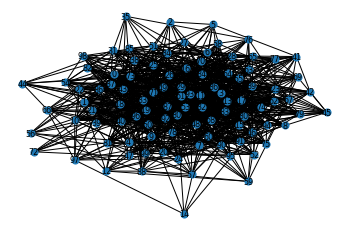

In [25]:
draw_graph(G)

Ploting epsitemic coverage

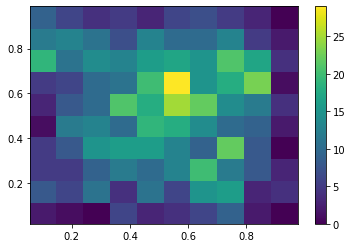

In [26]:
plot_epistemic_coverage(epistemic_coverage)

Plotting degree distribution

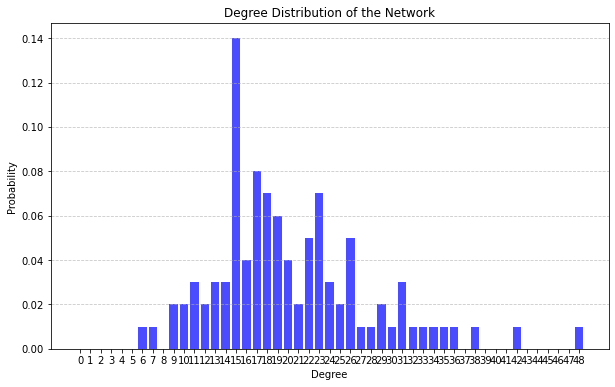

In [27]:
plot_degree_distribution(G)

## PP Model 

Collaboration and publication both depend upon mean prestige

In [28]:
G=initialize_network(number_of_authors,10)


In [29]:
epistemic_coverage=evolve_network_PP(G,epistemic_space,100,attempt_per_time_step)
print(G.number_of_edges())

1010


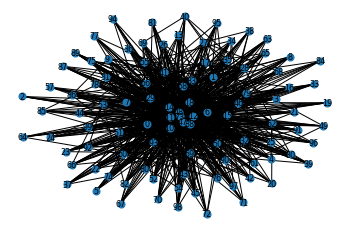

1010


In [30]:
draw_graph(G)
print(G.number_of_edges())

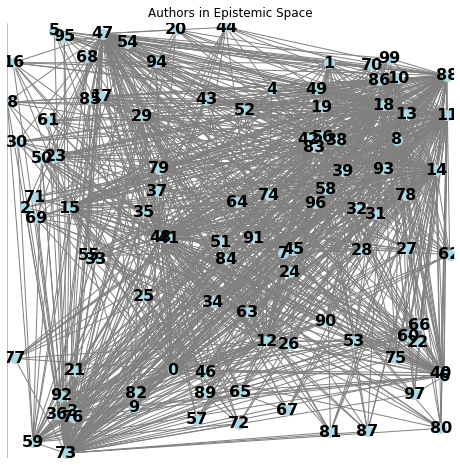

In [31]:
draw_network_in_epistemic_space(G,epistemic_space)



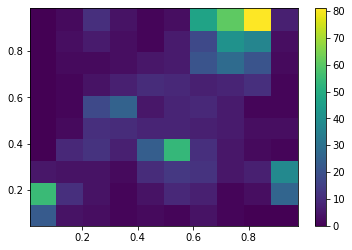

In [32]:
plot_epistemic_coverage(epistemic_coverage)

In [33]:
print(sum(list_degrees(G)),G.number_of_edges())


2020 1010


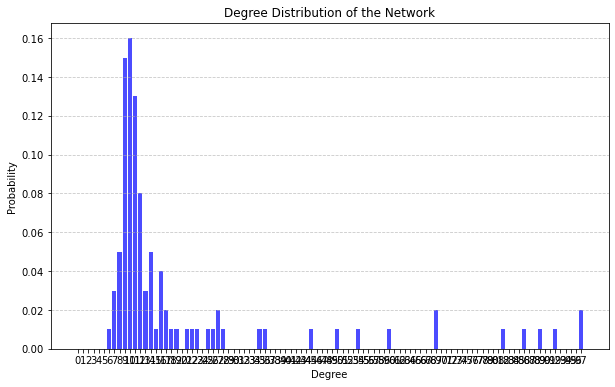

In [34]:
plot_degree_distribution(G)

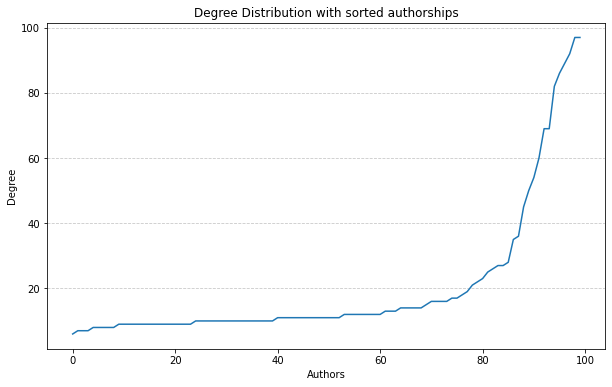

In [35]:
plot_sorted_degree_distribution(G)

In [36]:
#run_network_simulation(G,epistemic_space,time_steps,attempt_per_time_step)

## Combined Results

Function to show Degree Distribution for PP,PW,WP,WW models side by side

In [37]:
def degree_distribution_combined(G1,G2,G3,G4):
    """
    Shows the sorted degree distribution for 4 given graphs
 
    Args:
        G1 (graph): Network of authors
        G2 (graph): Network of authors
        G3 (graph): Network of authors
        G4 (graph): Network of authors
                
    Returns:
        float: 1D array of size equal to number of authors
    """
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20,5))

    ax1.plot(np.sort(list_degrees(G1)))

    ax1.set_title('WP')
    ax1.set_xlabel('Authors')
    ax1.set_ylabel('# Authorships')
    ax1.grid(True)

    ax2.plot(np.sort(list_degrees(G2)))
    ax2.set_title('PP')
    ax2.set_xlabel('Authors')
    ax2.set_ylabel('# Authorships')
    ax2.grid(True)
    
    ax3.plot(np.sort(list_degrees(G3)))
    ax3.set_title('PW')
    ax3.set_xlabel('Authors')
    ax3.set_ylabel('# Authorships')
    ax3.grid(True)
    
    ax4.plot(np.sort(list_degrees(G4)))
    ax4.set_title('WW')
    ax4.set_xlabel('Authors')
    ax4.set_ylabel('# Authorships')
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()    

Function to show heatmap of Epistemic Coverage for PP and WP models side by side

In [38]:
def heatmap_combined(ec1,ec2,ec3,ec4):
    """
    Plots the heat map of epsitemic coverages for 4 given graphs
 
    Args:
        ec1 (float): epistemic coverage for a given graph
        ec2 (float): epistemic coverage for a given graph
        ec3 (float): epistemic coverage for a given graph
        ec4 (float): epistemic coverage for a given graph
                
    Returns:
        float: 2D array of size equal to number of authors
    """

    
    x1=np.zeros(len(ec1))
    y1=np.zeros(len(ec1))
    x2=np.zeros(len(ec2))
    y2=np.zeros(len(ec2))
    x3=np.zeros(len(ec3))
    y3=np.zeros(len(ec3))
    x4=np.zeros(len(ec4))
    y4=np.zeros(len(ec4))

    for i in range(len(ec1)):
        x1[i]=ec1[i][0]
        y1[i]=ec1[i][1]

    for i in range(len(ec2)):
        x2[i]=ec2[i][0]
        y2[i]=ec2[i][1]
        
    for i in range(len(ec3)):
        x3[i]=ec3[i][0]
        y3[i]=ec3[i][1]

    for i in range(len(ec4)):
        x4[i]=ec4[i][0]
        y4[i]=ec4[i][1]

    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20,5))

    
    h = ax1.hist2d(x1, y1)
    fig.colorbar(h[3], ax=ax1)
    ax1.set_title('WP')
    ax1.grid(True)

    h = ax2.hist2d(x2, y2)
    fig.colorbar(h[3], ax=ax2)
    ax2.set_title('PP')
    ax2.grid(True)
    
    h = ax3.hist2d(x3, y3)
    fig.colorbar(h[3], ax=ax3)
    ax3.set_title('PW')
    ax3.grid(True)
    
    h = ax4.hist2d(x4, y4)
    fig.colorbar(h[3], ax=ax4)
    ax4.set_title('WW')
    ax4.grid(True)

Function to show Network on heatmap for PP and WP models side by side

In [39]:
def network_on_heatmap(G1,G2,G3,G4,ec1,ec2,ec3,ec4):
     """
    Plots the heat map of epsitemic coverages for 4 given graphs in epistemic space
 
    Args:
        G1 (graph): network of authors
        G2 (graph): network of authors
        G3 (graph): network of authors
        G4 (graph): network of authors
        ec1 (float): epistemic coverage for a given graph
        ec2 (float): epistemic coverage for a given graph
        ec3 (float): epistemic coverage for a given graph
        ec4 (float): epistemic coverage for a given graph
        
                
    Returns:
        float: 2D array of size equal to number of authors
    """

    x1=np.zeros(len(ec1))
    y1=np.zeros(len(ec1))
    for i in range(len(ec1)):
        x1[i]=ec1[i][0]
        y1[i]=ec1[i][1]
    coordinates1 =ec1
    pos1 = {i: (coordinates1[i][0], coordinates1[i][1]) for i in range(len(coordinates1))}
    
    
    x2=np.zeros(len(ec2))
    y2=np.zeros(len(ec2))
    for i in range(len(ec2)):
        x2[i]=ec2[i][0]
        y2[i]=ec2[i][1]
    coordinates2 =ec2
    pos2 = {i: (coordinates2[i][0], coordinates2[i][1]) for i in range(len(coordinates2))}
    
    x3=np.zeros(len(ec3))
    y3=np.zeros(len(ec3))
    for i in range(len(ec3)):
        x3[i]=ec3[i][0]
        y3[i]=ec3[i][1]
    coordinates3 =ec3
    pos3 = {i: (coordinates3[i][0], coordinates3[i][1]) for i in range(len(coordinates3))}
    
    x4=np.zeros(len(ec4))
    y4=np.zeros(len(ec4))
    for i in range(len(ec4)):
        x4[i]=ec4[i][0]
        y4[i]=ec4[i][1]
    coordinates4 =ec4
    pos4 = {i: (coordinates4[i][0], coordinates4[i][1]) for i in range(len(coordinates4))}






    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20, 5))

    h = ax1.hist2d(x1, y1)
    fig.colorbar(h[3], ax=ax1)
    nx.draw(G1, pos=pos1,ax=ax1,alpha=0.4, node_size=10, node_color='red', edge_color='gray')
    ax1.set_title('WP')
    ax1.grid(True)

    h = ax2.hist2d(x2, y2)
    fig.colorbar(h[3], ax=ax2)
    nx.draw(G2,pos= pos2,ax=ax2,alpha=0.4, node_size=10, node_color='lightblue', edge_color='gray')
    ax2.set_title('PP')
    ax2.grid(True)
    
    h = ax3.hist2d(x3, y3)
    fig.colorbar(h[3], ax=ax3)
    nx.draw(G3,pos= pos3,ax=ax3,alpha=0.4, node_size=10, node_color='lightblue', edge_color='gray')
    ax3.set_title('PW')
    ax3.grid(True)
    
    h = ax4.hist2d(x4, y4)
    fig.colorbar(h[3], ax=ax4)
    nx.draw(G4,pos= pos4,ax=ax4,alpha=0.4, node_size=10, node_color='lightblue', edge_color='gray')
    ax4.set_title('WW')
    ax4.grid(True)


### Random initialization of epistemic space 

Initializing variables

In [40]:
G1=initialize_network(number_of_authors,10)
G2=initialize_network(number_of_authors,10)
G3=initialize_network(number_of_authors,10)
G4=initialize_network(number_of_authors,10)
epistemic_space=initialize_epistemic_space(number_of_authors)

Heat map for the Epistemic space

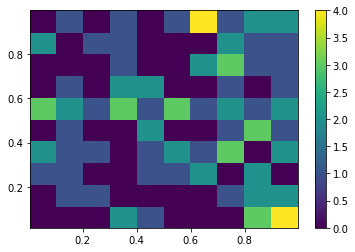

In [41]:
plot_epistemic_coverage(epistemic_space)

Evolving networks using PP and WP models

In [42]:
ec1=evolve_network_WP(G1,epistemic_space,time_steps,attempt_per_time_step)
ec2=evolve_network_PP(G2,epistemic_space,time_steps,attempt_per_time_step)


In [43]:
ec3=evolve_network_PW(G3,epistemic_space,time_steps,attempt_per_time_step)
ec4=evolve_network_WW(G4,epistemic_space,time_steps,attempt_per_time_step)

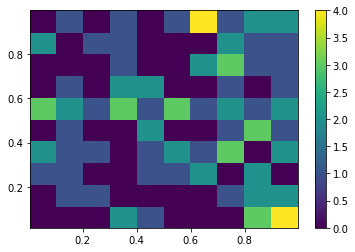

In [46]:
plot_epistemic_coverage(epistemic_space)

Degree Distribution

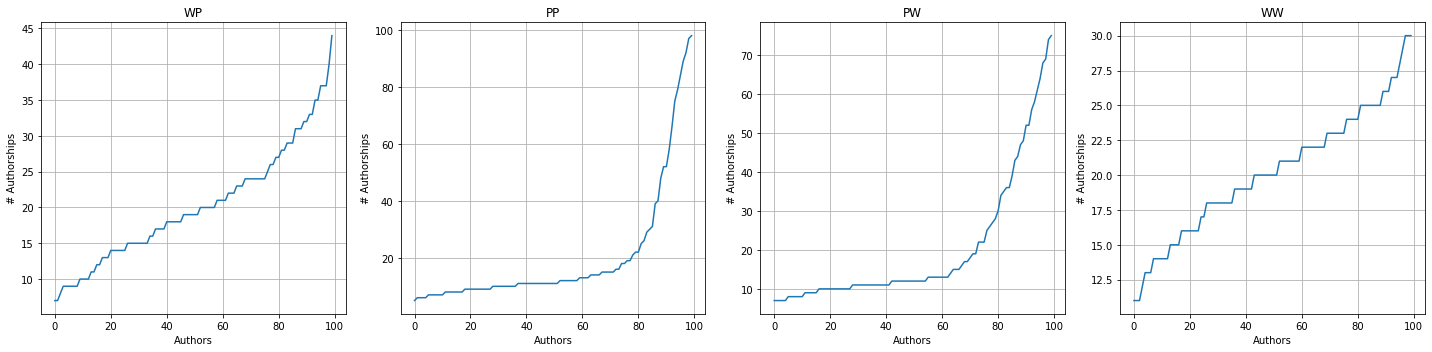

In [47]:
degree_distribution_combined(G1,G2,G3,G4)

Epsitemic coverage heat map

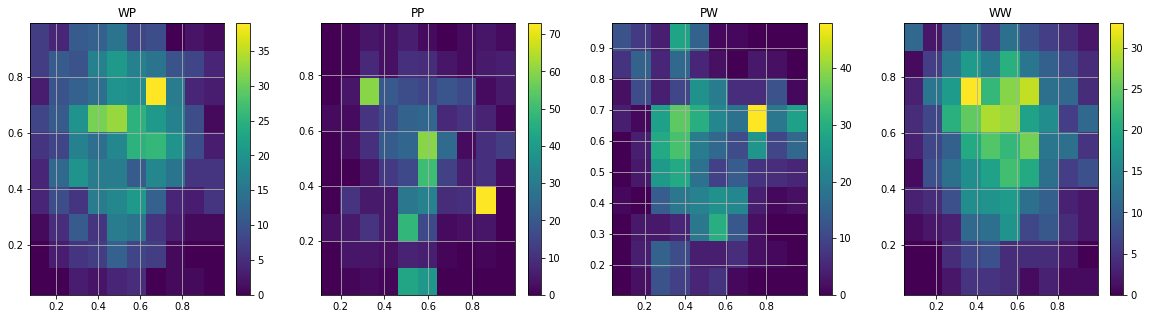

In [48]:
heatmap_combined(ec1,ec2,ec3,ec4)

Network in Epistemic space

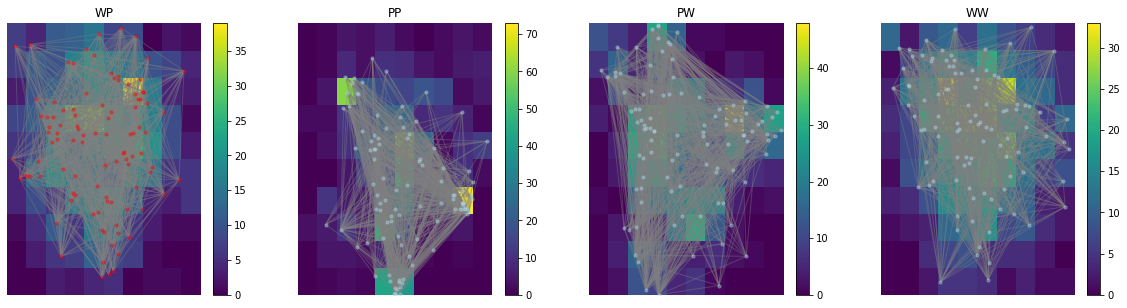

In [49]:
network_on_heatmap(G1,G2,G3,G4,ec1,ec2,ec3,ec4)


### Uniform initialization of epistemic space

In [146]:
G1=initialize_network(number_of_authors,10)
G2=initialize_network(number_of_authors,10)
G3=initialize_network(number_of_authors,10)
G4=initialize_network(number_of_authors,10)
epistemic_space=initialize_agents_grid(number_of_authors)

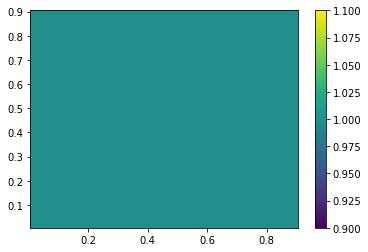

In [147]:
plot_epistemic_coverage(epistemic_space)

In [150]:
ec1=evolve_network_WP(G1,epistemic_space,time_steps,attempt_per_time_step)
ec2=evolve_network_PP(G2,epistemic_space,time_steps,attempt_per_time_step)


In [148]:
ec3=evolve_network_PW(G3,epistemic_space,time_steps,attempt_per_time_step)


In [149]:
ec4=evolve_network_WW(G4,epistemic_space,time_steps,attempt_per_time_step)

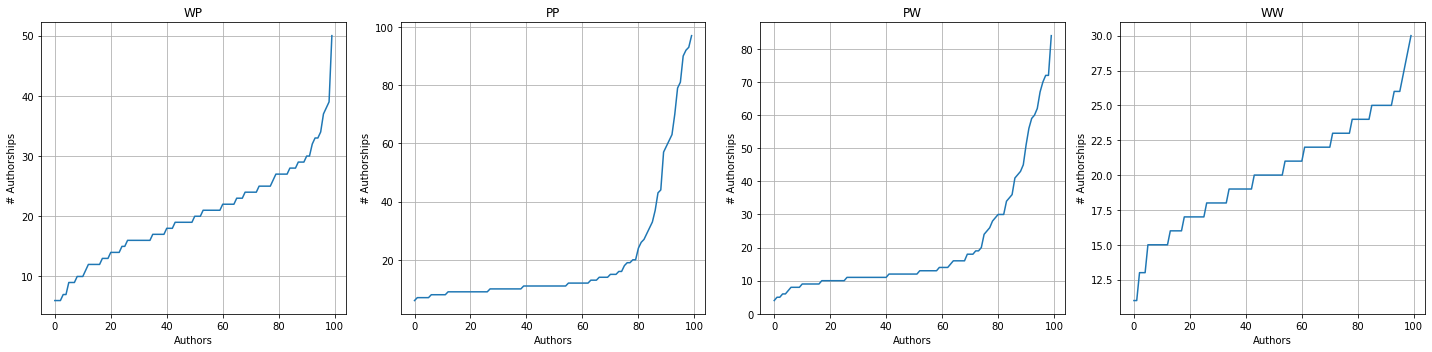

In [151]:
degree_distribution_combined(G1,G2,G3,G4)

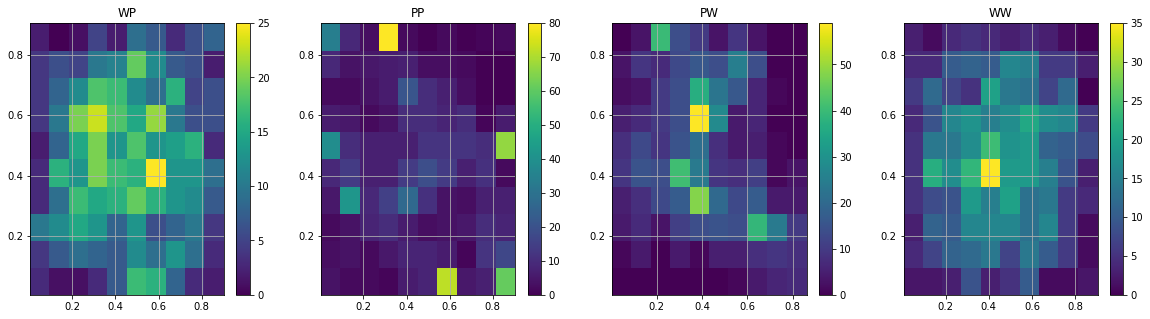

In [152]:
heatmap_combined(ec1,ec2,ec3,ec4)

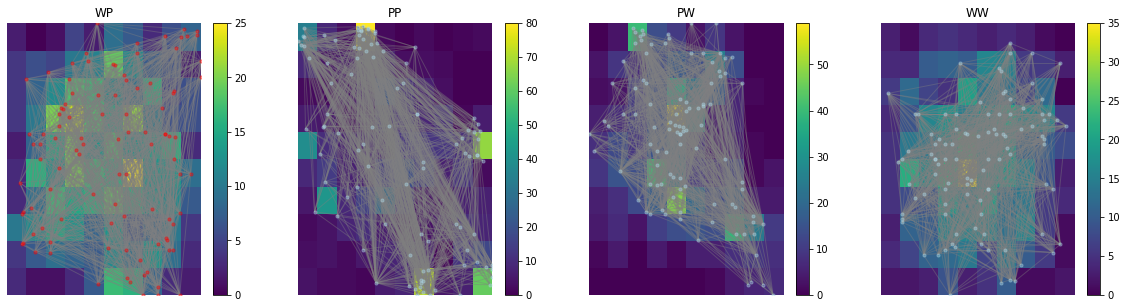

In [154]:
network_on_heatmap(G1,G2,G3,G4,ec1,ec2,ec3,ec4)